# I. Trend

* Model long-term changes with moving averages and the time dummy

## 1. What is **Trend**?

The trend component of a time series represents a persistent, long-term change in the **mean** of the series. 

The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. 

In a time series of product sales, an increasing trend might be the effect of a **market expansion** as more people become aware of the product year by year.

In this course, we'll focus on **trends in the mean**. More generally though, any persistent and slow-moving change in a series could constitute a trend -- time series commonly have trends in their variation for instance.

## 2. Moving Average Plots

To see what kind of trend a time series might have, we can use a **moving average** plot. 

To compute a moving average of a time series, we compute the average of the values within **a sliding window of some defined width**. Each point on the graph represents the average of all the values in the series that fall within the window on either side. 

The idea is to smooth out any short-term fluctuations in the series so that only **long-term** changes remain.

To visualize a trend, we take an average over a period longer than any **seasonal** period in the series.

## 3. Engineering Trend

Once we've identified the shape of the trend, we can attempt to model it using a **time-step feature**. We've already seen how using the time dummy itself will model a linear trend:

> target = a * time + b

We can fit many other kinds of trend through **transformations** of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us:

> target = a * time ** 2 + b * time + c

Linear regression will learn the coefficients a, b, and c.

Note that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

# II. Seasonality

* Create indicators and Fourier features to capture periodic change

## 1. What is Seasonality?

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the **mean** of the series. 

Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. 

Seasonality is often driven by the **cycles** of the natural world over days and years or by conventions of social behavior surrounding dates and times.

For example, electricity demand, temperature of a city (like Seattle), Lyft rides in NYC, Dutch retail sales.

We will learn two kinds of features that model seasonality. The first kind, **indicators**, is best for a season with few observations, like a weekly season of daily observations. The second kind, **Fourier features**, is best for a season with many observations, like an annual season of daily observations.

## 2. Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted **against some common period**, the period being the "season" you want to observe. 

### (1) Seasonal indicators

Seasonal indicators are **binary** features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a **categorical** feature and apply **one-hot encoding**.

By one-hot encoding days of the week, we get **weekly** seasonal indicators. Creating weekly indicators for the data series will then give us **six new "dummy" features**. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)

Adding seasonal indicators to the training data helps models **distinguish** means within a seasonal period -- meaning: you can clearly see that the data aligns with the seasonal trend. 

The indicators act as **On / Off switches**. At any time, at most one of these indicators can have a value of 1 (On). 

For this model, linear regression learns a baseline value 2379 for Mon and then adjusts by the value of whichever indicator is On for that day; the rest are 0 and vanish.

### (2). Fourier Features and the Periodogram

The kind of feature we discuss now are better suited for **long seasons over many observations** where indicators would be impractical. Instead of creating a feature for each date, **Fourier features** try to capture the **overall shape** of the seasonal curve with just a few features.

It is these **frequencies within a season** that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of **the trigonometric functions sine and cosine**.

Fourier features are **pairs** of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the **weights** that will fit the seasonal component in the target series. 

For example, linear regression can use four Fourier pairs (in total 8 features, aka four sine / cosine pairs) to model the annual seasonality in the training data series.

Notice that we only needed eight features to get a good estimate of the annual seasonality, compared with the seasonal indicator method which would have required hundreds of features (one for each day of the year). 

By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to **add far fewer features** to your training data, which means reduced computation time and less risk of overfitting.

#### Choosing Fourier features with the Periodogram

How many Fourier pairs should we actually include in our feature set? We can answer this question with the **periodogram**.

The periodogram tells you the **strength of the frequencies** in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2`, where a and b are the coefficients of the sine and cosine at that frequency.

From left to right, the periodogram **drops off** after Quarterly, **four** times a year. That was why we chose **four** Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

#### Computing Fourier features (optional)

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from statsmodels for our applications, however.)

In [1]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

## III. Serial Dependence (Time Series as Features)

### 1. What is Serial Dependence?

Previously, we investigated properties of time series that were most easily modeled as **time dependent properties**, that is, with features we could derive directly from the time index. 

Some time series properties, however, can only be modeled as **serially dependent properties**, that is, using as features past values of the target series. 

The structure of these time series may not be apparent from a plot over time; **plotted against past values**, however, the structure becomes clear.

With trend and seasonality, we trained models to fit curves to plots like those where the models were learning time dependence. The goal in this lesson is to train models to fit curves to plots like those where we want them to learn **serial dependence**.

#### Cycles

One especially common way for serial dependence to manifest is in **cycles**. 

Cycles are **patterns of growth and decay** in a time series associated with how the value in a series at one time depends on values at previous times, but **not necessarily on the time step itself**. 

Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. 

Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

To be more specific, US employment goes up and down -- it is in cycles. 

What distinguishes **cyclic** behavior from **seasonality** is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about **what has happened in the recent past**. The (at least relative) independence from time means that cyclic behavior can be much more **irregular** than seasonality.

### 2. Lagged Series and Lag Plots

To investigate possible serial dependence (like cycles) in a time series, we need to create **"lagged" copies** of the series. 

Lagging a time series means to shift its values **forward** one or more time steps, or equivalently, to shift the times in its index **backward** one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (y) together with its first and second lagged series (y_lag_1 and y_lag_2, respectively). Notice how the values of the lagged series are **shifted forward** in time.

In [1]:
import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

In [2]:
y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


By lagging a time series, we can make its past values appear **contemporaneous** with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as **features** for modeling serial dependence. 

To forecast the US unemployment rate series, we could use `y_lag_1` and `y_lag_2` as features to predict the target `y`. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

### Lag plots

A lag plot of a time series shows its values **plotted against its lags**. Serial dependence in a time series will often become apparent by looking at a lag plot. 

We can see from this lag plot of US Unemployment that there is a strong and apparently **linear** relationship between the current unemployment rate and past rates.

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
# Train the model
X = df.loc[:, ['y_lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'y']
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [23]:
model.coef_

array([0.99316623])

In [25]:
round(model.coef_[0], 2)

0.99

In [37]:
"%s" % model.coef_[0], str(model.coef_[0]), '{0:f}'.format(model.coef_[0])

('0.9931662281273951', '0.9931662281273951', '0.993166')

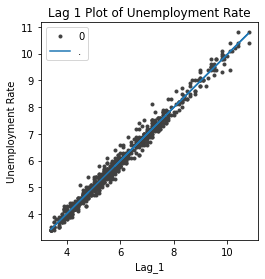

In [35]:
# plot against lag_1
fig, ax = plt.subplots()
ax.plot(X, y, '.', color='0.25')
ax.plot(X, y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Lag_1')
ax.set_title('Lag 1 Plot of Unemployment Rate')
ax.legend("%s" % model.coef_[0], loc="upper left");

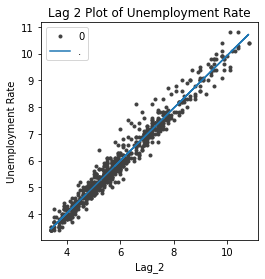

In [38]:
# Train the model
X = df.loc[:, ['y_lag_2']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'y']
y, X = y.align(X, join='inner')  # drop corresponding values in target

model_2 = LinearRegression()
model_2.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model_2.predict(X), index=X.index)

# plot against lag_2
fig, ax = plt.subplots()
ax.plot(X, y, '.', color='0.25')
ax.plot(X, y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Lag_2')
ax.set_title('Lag 2 Plot of Unemployment Rate')
ax.legend("%s" % model_2.coef_[0], loc="upper left");

In [39]:
model_2.coef_[0]

0.9840272898663868

The most commonly used measure of serial dependence is known as **autocorrelation**, which is simply the correlation a time series has with one of its lags. US Unemployment has an autocorrelation of 0.99 at lag 1, 0.98 at lag 2, and so on.

### Choosing lags

When choosing lags to use as features, it generally won't be useful to include every lag with a large autocorrelation. In US Unemployment, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything **new**, there would be no reason to include it if we already have lag 1.

The **partial autocorrelation** tells you the correlation of a lag accounting for all of the **previous lags** -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose **which lag features to use**. 

In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for US Unemployment. (Lag 11 is likely a false positive.)

In [4]:
y.head()

Date
1954-07    5.8
1954-08    6.0
1954-09    6.1
1954-10    5.7
1954-11    5.3
Freq: M, Name: Unemployment Rate, dtype: float64

In [5]:
df_y = pd.DataFrame({
    'y': y
})

In [6]:
import numpy as np

np.__version__

'1.21.6'

In [7]:
import statsmodels
statsmodels.__version__

'0.13.2'

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [12]:
plot_pacf?

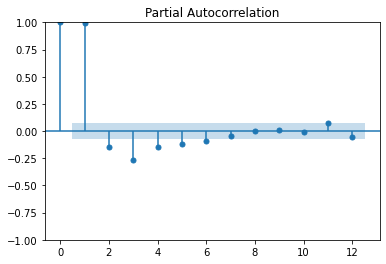

In [16]:
plot_pacf(df_y, lags = 12, method = 'ywm')
plt.show();

Partial autocorrelations of US Unemployment through lag 12 with 95% confidence intervals of no correlation

A plot like that above is known as a **correlogram**. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of **linear** dependence. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like **mutual information**) when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation.

Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.

## IV. Hybrid Models

combine the strengths of two forecasters with this powerful technique

### 1. Introduction

Linear regression excels at extrapolating trends, but can't learn interactions. **XGBoost** excels at learning interactions, but can't extrapolate trends. In this lesson, we'll learn how to create **"hybrid" forecasters** that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

### 2. Components and Residuals

So that we can design effective hybrids, we need a better understanding of **how time series are constructed**. We've studied up to now three patterns of **dependence**: `trend`, `seasons`, and `cycles`. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random error:

`series = trend + seasons + cycles + error`

Each of the terms in this model we would then call a **component** of the time series.

The residuals of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the **"left over"** part of the target, or what the model failed to learn about the target from that feature.

We could imagine learning the components of a time series as an iterative process: first learn the **trend** and subtract it out from the series, then learn the **seasonality** from the detrended residuals and subtract the seasons out, then learn the **cycles** and subtract the cycles out, and finally only the unpredictable error remains.

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

### 3. Hybrid Forecasting with Residuals
Previously, we used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the **original** series and then the second algorithm to fit the **residual** series.

> In detail, the process is this:

> # 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

> # 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

> # 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

We'll usually want to use different feature sets (X_train_1 and X_train_2 above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a **simple (usually linear)** learning algorithm followed by a **complex, non-linear learner like GBDTs** or a **deep neural net**, the simple model typically designed as a "helper" for the powerful algorithm that follows.

### 4. Designing Hybrids

There are many ways you could combine machine learning models besides the way we've outlined. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.

There are generally **two ways** a regression algorithm can make predictions: either by transforming the `features` or by transforming the `target`. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. **Linear regression** and **neural nets** are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. **Decision trees** and **nearest neighbors** are of this kind.

The important thing is this: feature transformers generally can **extrapolate** target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. **Decision trees cannot extrapolate trends.** Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

This difference is what motivates the hybrid design in this lesson: **use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals**. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted** hybrids; the method of using predictions as features is known as **"stacking"**, so we will call these **stacked** hybrids.

> Winning Hybrids from Kaggle Competitions
For inspiration, here are a few top scoring solutions from past competitions:
> * STL boosted with exponential smoothing - Walmart Recruiting - Store Sales Forecasting
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125
> * ARIMA and exponential smoothing boosted with GBDT - Rossmann Store Sales
https://www.kaggle.com/c/rossmann-store-sales/discussion/17896
> * An ensemble of stacked and boosted hybrids - Web Traffic Time Series Forecasting
https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395
> * Exponential smoothing stacked with LSTM neural net - M4 (non-Kaggle)
https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf

## V. Forecasting With Machine Learning

Apply ML to any forecasting task with these four strategies.

### 1. Introduction

Previously, we treated forecasting as a simple regression problem with all of our features derived from a single input, the **time index**. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features.

When we added lag features, however, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

Previously, we just assumed that we could always generate lags up to the period we wanted to forecast (every prediction was for just one step forward, in other words). Real-world forecasting typically demands more than this, so in this lesson we'll learn how to make forecasts for a variety of situations.

### 2. Defining the Forecasting Task

There are two things to establish before designing a forecasting model:

* what information is available at the time a forecast is made (features), and,
* the time period during which you require forecasted values (target).

The **forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to the origin can be used to create features.

The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.

The time between the origin and the horizon is the **lead time** (or sometimes **latency**) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

### 3. Preparing Data for Forecasting

In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless, of course, you are only using deterministic features like trend and seasonality.)

We saw the first half of this process previously when we created a feature set out of lags. The second half is preparing the target. How we do this depends on the forecasting task.

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [1]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

The above illustrates how a dataset would be prepared similar to the **Defining a Forecast** figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is y_step_1. The missing values we could either fill-in or drop.

### 4. Multistep Forecasting Strategies

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline **four** common strategies, each with strengths and weaknesses.

#### (1). Multioutput model
Use a model that produces multiple outputs naturally. `Linear regression` and `neural networks` can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. `XGBoost` can't do this, for instance.

#### (2). Direct strategy
Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

#### (3). Recursive strategy
Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since **errors will propagate from step to step**, forecasts can be inaccurate for long horizons.

#### (4). DirRec strategy
A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture **serial dependence** better than Direct, but it can also suffer from error propagation like Recursive.